THE SCHEDULING PROBLEM

In [1]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from itertools import product
import networkx as nx
import matplotlib.pyplot as plt


# Define identity and Z matrices as Pauli strings
Z = 'Z'
I = 'I'

# Function to generate SparsePauliOp
def kronecker_product(operators, coeff, N):
    # Construct the Pauli string by joining the operators
    pauli_string = ''.join(operators)

    # Create the SparsePauliOp with the given coefficient
    return SparsePauliOp.from_list([(pauli_string, coeff)], num_qubits=N)

/home/uni_x/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
#Object oriented problem statement:
class scheduling_problem():
    def __init__(self, M, J, E, run_times):
        self.M = M
        self.J = J
        self.E = E
        self.run_times = run_times
        self.T = np.sum(run_times)
    
    #Needs to define hamiltonian
    def get_hamiltonian():
        pass

######

class seperate_index_scheduling_problem(scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J * self.T
        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)

    #Function to access the qubit from its m,j,t index
    #@params
    # @@@ m - machine index
    # @@@ j - job index
    # @@@ t - time index
    def get_indicator_index(self, m, j, t):
        return m + self.M * j + self.M * self.J * t

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t') -> (1-a)*(1-b)-> -a-b+ab
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)
        
        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        #Loop through all combinations that need Z:
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)): #Note - it is not run_times[j] - 1, since range doesn't include the edge 
                            self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)

    def H_dependency(self, penalty_coeff):
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)): #Note - run_times[j] - 1 
                            self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        ###

        for j in range(self.J):
            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, (1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(t, self.T): #need to multiply the coeff
                            if(t == t_tag and m == m_tag): #Only in this case we can skip
                                continue
                            operators = [I] * self.num_qubits
                            operators[self.get_indicator_index(m,j,t)] = Z
                            operators[self.get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)

    def H_finish_time(self):
        #Loop through all combinations that need Z:
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

        
    def get_hamiltonian(self, penalty_coeff):
        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        #All conditions
        self.H_no_parallel_execution(penalty_coeff)
        self.H_dependency(penalty_coeff)
        self.H_force_run(penalty_coeff)
        self.H_finish_time()

        return self.term
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [3]:
class seperate_index_full_values_scheduling_problem(scheduling_problem):
    #Represents the full hamiltonian without constants dropped out
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J * self.T

    #Function to access the qubit from its m,j,t index
    def get_indicator_index(self, m, j, t):
        return m + self.M * j + self.M * self.J * t

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t') -> 0.25(1-a)*(1-b)-> 0.25(1-a-b+ab)
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        #Identity term
        operators = [I] * self.num_qubits
        term += kronecker_product(operators, 0.25 * penalty_coeff, self.num_qubits)

        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        term += kronecker_product(operators, -0.25 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        term += kronecker_product(operators, -0.25 * penalty_coeff, self.num_qubits)
        
        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        term += kronecker_product(operators, 0.25*penalty_coeff, self.num_qubits)

        return term

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)): #Note - from t'=t because maybe the job finished way earlier
                            term += self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)
                            #print(f"(m,j,t)={(m,j,t)},(m',j',t')={(m,j_tag,t_tag)}")
        return term

    def H_dependency(self, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)): #Note - from t'=0 because it cannot happen before j
                            #print(f"#dep: {(m,j,t)} & {(m_tag, j_tag, t_tag)}")
                            term += self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)
        return term

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for j in range(self.J):
            operators = [I] * self.num_qubits
            term += kronecker_product(operators, (1 - self.M * self.T / 2)*(1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j,t)] = Z
                    term += kronecker_product(operators, (1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(self.T):
                            operators = [I] * self.num_qubits
                            operators[self.get_indicator_index(m,j,t)] = Z
                            operators[self.get_indicator_index(m_tag,j,t_tag)] = Z
                            if(m == m_tag and t == t_tag):
                                operators[self.get_indicator_index(m_tag,j,t_tag)] = I

                            term += kronecker_product(operators, 0.25 * penalty_coeff, self.num_qubits)
                            #print(f"(m,j,t)={(m,j,t)},(m',j',t')={(m_tag,j,t_tag)}")
        return term

    def H_finish_time(self):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    operators = [I] * self.num_qubits
                    term += kronecker_product(operators, (0.5) * t, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j_dummy,t)] = Z
                    term += kronecker_product(operators, (-0.5) * t, self.num_qubits)
        return term

        
    def get_hamiltonian(self, penalty_coeff):
        return self.H_no_parallel_execution(penalty_coeff) + self.H_dependency(penalty_coeff) + self.H_force_run(penalty_coeff) + self.H_finish_time()
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [4]:
class xy_method_base_scheduling_problem(scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J + self.T * self.J

        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)

    #X_(m,j) and Y_(t,j) are two binary vectors appended together
    def X_get_indicator_index(self, m, j, t):
        return m + self.M * j
    
    def Y_get_indicator_index(self, m, j, t):
        return self.M * self.J + j + self.J * t #Y occurs after all of X

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t')
    #Note that x_(m,j,t) = X_(m,j) * Y_(t,j) so the expansion is different
    #-> (1-a)(1-b)(1-c)(1-d)-> -a-b-c-d+ab+bc+cd+ad+ac+bd-abc-bcd-cda-dba+abcd
    #a=X_m,j; b=Y_m,j; c=X_m',j'; d=Y_m',j'
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        a = self.X_get_indicator_index(m,j,t)
        b = self.Y_get_indicator_index(m,j,t)
        c = self.X_get_indicator_index(m_tag,j_tag,t_tag)
        d = self.Y_get_indicator_index(m_tag,j_tag,t_tag)
        
        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[a] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)
        
        operators = [I] * self.num_qubits
        operators[c] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        #Negative cubic terms:
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        #Positive quartic term:
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)):
                            self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)

    def H_dependency(self, penalty_coeff):
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)):
                            self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        #if there is a bug, it is most of the time here :)
        for j in range(self.J):
            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j,t)] = Z
                    operators[self.Y_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, -1 * 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)

            #Quadratic terms:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(self.T):
                            if(m == m_tag and t == t_tag):
                                continue
                            #Quadratic terms: (x+y-xy)^2 -> xy' + x'y + xx' + yy'
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            #Cubic terms: -> -2x^2y-2xy^2
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, -1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, -1/16 * penalty_coeff, self.num_qubits)

                            #Quartic term xyx'y':
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

    def H_finish_time(self):
        #Loop through all combinations that need Z:
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    #Term: X_m,j,t -> (1-a)(1-b) -> -a-b+ab, a=X_m,j ; b=Y_t,j
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j_dummy,t)] = Z
                    operators[self.Y_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, t, self.num_qubits)

        
    def get_hamiltonian(self, penalty_coeff):
        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        #All conditions
        self.H_no_parallel_execution(penalty_coeff)
        self.H_dependency(penalty_coeff)
        self.H_force_run(penalty_coeff)
        self.H_finish_time()

        return self.term
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        
        print(f"M={self.M}, J={self.J}, T={self.T}")
        print(f"X={binary_solution[ : self.M*self.J]}, Y={binary_solution[self.M*self.J : ]}")

        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.X_get_indicator_index(m,j,t)] == '1' and binary_solution[self.Y_get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [5]:
class xy_method_scheduling_problem(xy_method_base_scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)
    
    def H_force_run(self, penalty_coeff): #Force every job to run once.
        #New idea - seperately enforce the condition on X and on Y
        
        #For X #Only looks for machines
        for j in range(self.J):
            for m in range(self.M):
                operators = [I] * self.num_qubits
                operators[self.X_get_indicator_index(m,j,0)] = Z
                self.term += kronecker_product(operators, (1 - self.M / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(m+1, self.M): #need to multiply the coeff
                        operators = [I] * self.num_qubits
                        operators[self.X_get_indicator_index(m,j,None)] = Z
                        operators[self.X_get_indicator_index(m_tag,j,None)] = Z
                        self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)
        
        #For Y
        for j in range(self.J):
            for t in range(self.T):
                operators = [I] * self.num_qubits
                operators[self.Y_get_indicator_index(None,j,t)] = Z
                self.term += kronecker_product(operators, (1 - self.T / 2) * penalty_coeff, self.num_qubits)

            for t in range(self.T):
                for t_tag in range(t+1, self.T): #need to multiply the coeff
                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(None,j,t)] = Z
                    operators[self.Y_get_indicator_index(None,j,t_tag)] = Z
                    self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)

In [146]:
# Define a sample problem
#Note, the last job is the dummy job
#M = 2
#J = 3
#E = [(0, 2), (1,2)]
#run_times = np.array([1,2,1])

#### TEST 0 - 4 qubits PASSED
M = 1
J = 2
E = [(0,1)]
run_times = np.array([1,1])
####

#### TEST 1 - 9 qubits PASSED
#M = 1
#J = 2
#E = [(0,1)]
#run_times = np.array([1,1])
####

#### TEST 2 - 18 qubits PASSED
#M = 2
#J = 2
#E = [(1,0), (2,1)]
#run_times = np.array([1,1,0])
####

#seperate_index_full_values_scheduling_problem vs seperate_index_scheduling_problem vs xy_method_scheduling_problem
task = seperate_index_full_values_scheduling_problem(M, J, E, run_times)

#print(task.X_get_indicator_index(0,1,1))
#print(task.Y_get_indicator_index(0,0,0))

penalty_coeff = 100

print(f"Solver: {type(task)}")
print(f"Used {task.num_qubits} qubits")
H_total_JSP = task.get_hamiltonian(penalty_coeff)

Solver: <class '__main__.seperate_index_full_values_scheduling_problem'>
Used 9 qubits


In [147]:
import numpy as np

def kronker_vector_to_binary(vector):
    # Find the index of the non-zero element
    index = np.argmax(vector)
    
    # Convert the index to binary representation
    n = int(np.log2(len(vector)))  # Calculate the number of qubits
    binary_representation = format(index, f'0{n}b')  # Format index as binary with leading zeros
    
    # Create the quantum state string
    quantum_state = ''.join(binary_representation)
    
    return quantum_state

import itertools
def generate_binary_vectors(n):
    for vector in itertools.product([0, 1], repeat=n): #of Z eigenvalues
        yield np.array(vector)

def generate_one_hot_vectors(n):
    for i in range(n):
        vector = [0] * n  # Create a vector of zeros
        vector[i] = 1     # Set the i-th position to 1
        yield np.array(vector).reshape((n, 1)) # Yield the one-hot vector

def binary_to_kronker(binary_string):
    n = len(binary_string)
    # Convert binary string to decimal
    decimal_index = int(binary_string, 2)
    # Create a one-hot encoded vector of size 2^n
    one_hot_vector = [0] * (2 ** n)
    one_hot_vector[decimal_index] = 1
    return np.array(one_hot_vector).reshape((2 ** n, 1))

def get_eigenvalue_sparse(eigenvector, H_sparse):
    #Instead of  #eigenvector.T @ H_matrix @ eigenvector
    return H_sparse.reshape((-1)).dot(eigenvector ** 2) #np.sum((eigenvector**2) * H) #Elementwise

# Function to get the matrix representation of a single Pauli operator
def get_pauli_matrix(pauli):
    if pauli == 'I':
        return np.array([1,1])  # Identity matrix
    elif pauli == 'Z':
        return np.array([1,-1])  # Pauli Z matrix
    else:
        raise ValueError(f"Unknown Pauli operator: {pauli}")

def get_diagonal_kronker(sparse_pauli_op):
    # Get the Pauli strings and their coefficients
    pauli_strings = sparse_pauli_op.paulis
    coefficients = sparse_pauli_op.coeffs

    # Initialize the aggregate vector as the identity operator
    aggregate_vector = np.array((2**len(sparse_pauli_op.paulis[0]))*[0],dtype=np.complex128)  # Identity matrix for the initial Kronecker product
    
    # Calculate the aggregate Kronecker products
    for coeff, pauli_string in zip(coefficients, pauli_strings):
        if coeff == 0:
            continue

        # Start with the identity matrix for this specific Pauli string
        pauli_product = np.array([1])  # Identity matrix for the initial Kronecker product

        # Iterate over each character in the Pauli string
        for pauli in pauli_string[::-1]: #For some reason the pauli string is in the reverse direction than what it should be
            # Get the matrix representation of the current Pauli operator
            pauli_matrix = get_pauli_matrix(str(pauli))
            
            # Perform the Kronecker product with the current Pauli matrix
            pauli_product = np.kron(pauli_product, pauli_matrix)
        #print(f"{coeff}*{pauli_string}->{pauli_product}")

        # Scale the resulting product by its coefficient
        scaled_pauli_product = coeff * pauli_product
        
        # Aggregate the result
        aggregate_vector += scaled_pauli_product
        #print(aggregate_vector)
        
    return np.array(aggregate_vector).reshape((-1,1))

def get_diagonal_raw(H):
    H_matrix = H.to_matrix()
    print(f"H_matrix shape: {H_matrix.shape}")
    diag = H_matrix.diagonal().reshape((H_matrix.shape[0],1))
    del H_matrix
    return diag

In [148]:
#from scipy.linalg import eigh
import time

init = time.time()

#Convert SparsePauliOp to a dense matrix
print(f"Extract diagonal kronker")
H_diag = get_diagonal_kronker(H_total_JSP)
print(f"Finish {round(time.time()-init,1)}s")
init = time.time()

#print(H_total_JSP)
#print(H_diag)

min_eigenvalue = float("inf")
min_eigenvector = None

# print("Bruteforce eigenvalues")
# for eigenvector in generate_one_hot_vectors(2**task.num_qubits):
#     new_eigenvalue = get_eigenvalue(eigenvector, H_diag)
#     #print(new_eigenvalue)
    
#     #Find minimal eigenvalue
#     if(new_eigenvalue < min_eigenvalue):
#         min_eigenvalue = new_eigenvalue
#         min_eigenvector = eigenvector

print(f"Find mininum eigenvalue (numpy min)")
min_eigenvalue = np.min(H_diag)
min_eigenvector = binary_to_kronker(format(np.argmin(H_diag), f'0{task.num_qubits}b'))

print(f"Finish {round(time.time()-init,1)}s")
init = time.time()

#min_eigenvector = binary_to_kronker("010100001")

binary_solution = kronker_vector_to_binary(min_eigenvector)

print("Minimum Eigenvalue:", min_eigenvalue.real)
task.print_problem()
task.print_solution(binary_solution)

#For testing on the full hamiltonian version:
#print(f"<H_dependency>={min_eigenvector.T @ task.H_dependency(penalty_coeff).to_matrix() @ min_eigenvector}")
#get_expectation_value(state, op)  ###np.round(state.expectation_value(H_total_JSP).real, 10) (from: hamiltonians) state:Statevector

Extract diagonal kronker
Finish 0.6s
Find mininum eigenvalue (numpy min)
Finish 0.0s
Minimum Eigenvalue: 2.0
===Problem===
Run 2(+1 dummy) jobs on 1 machines.
Job Lengths: [1 1]
Dependency Graph [(0, 1), (0, 2), (1, 2)]
===
Quantum State (computational basis): |100010001>
===Solution===
t=0: Job #0 -> Machine #0
t=1: Job #1 -> Machine #0
t=2: Job #dummy -> Machine #0
===end===


In [149]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np
from hamiltonians import get_expectation_value

def initialize_circuit_from_string(state_string):
    # Create a quantum circuit with the appropriate number of qubits
    n = len(state_string)
    qc = QuantumCircuit(n)

    # Initialize the state vector
    state_vector = np.array([1])  # Start with the identity state |0⟩

    for char in state_string:
        if char == '0':
            state_vector = np.kron(state_vector, np.array([1, 0]))  # |0⟩
        elif char == '1':
            state_vector = np.kron(state_vector, np.array([0, 1]))  # |1⟩
        elif char == '+':
            state_vector = np.kron(state_vector, np.array([1/np.sqrt(2), 1/np.sqrt(2)]))  # |+⟩
        elif char == '-':
            state_vector = np.kron(state_vector, np.array([1/np.sqrt(2), -1/np.sqrt(2)]))  # |-⟩
        else:
            raise ValueError(f"Invalid character '{char}' in state string. Use 0, 1, +, or -.")

    # Initialize the quantum circuit with the state vector
    qc.initialize(state_vector, range(n))

    return qc

def initialize_state_from_string(state_string):
    return Statevector.from_instruction(initialize_circuit_from_string(state_string))


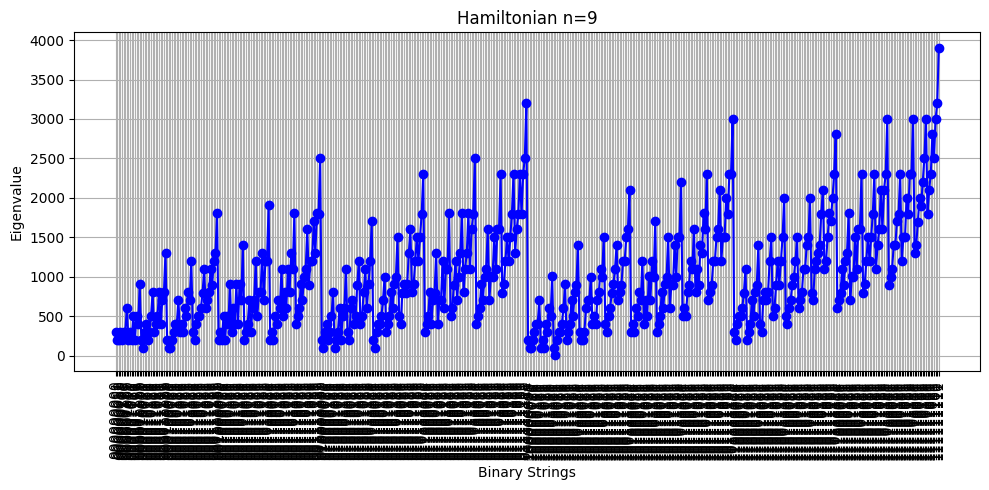

In [150]:
import numpy as np
import matplotlib.pyplot as plt

def foo(binary_string):
    # Example function: count the number of '1's in the binary string
    return get_expectation_value(initialize_state_from_string(binary_string), H_total_JSP)

def generate_binary_strings(n):
    total_strings = 2 ** n
    binary_strings = []
    
    for i in range(total_strings):
        binary_string = format(i, '0' + str(n) + 'b')
        binary_strings.append(binary_string)
    
    return binary_strings

def create_heatmap(n):
    binary_strings = generate_binary_strings(n)
    values = np.zeros((2**n, 1))  # Create an array to hold the function values

    for i, binary_string in enumerate(binary_strings):
        values[i] = foo(binary_string)

    # Reshape values for heatmap (1D to 2D)
    heatmap_data = values.reshape((2**n, 1))

    # Plotting the heatmap
    plt.figure(figsize=(10, 5))
    plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Function Value')
    plt.title(f'Heatmap of the eigenvalues n={n}')
    plt.xticks([])  # Hide x ticks
    plt.yticks(range(2**n), binary_strings)  # Show binary strings on y-axis
    plt.xlabel('Binary Strings')
    plt.ylabel('Function Values')
    plt.show()

def create_2d_graph(n):
    binary_strings = generate_binary_strings(n)
    values = np.zeros(2 ** n)  # Create an array to hold the function values

    for i, binary_string in enumerate(binary_strings):
        values[i] = foo(binary_string)

    # Create x values (indices of binary strings)
    x_values = np.arange(len(binary_strings))

    # Plotting the 2D graph
    plt.figure(figsize=(10, 5))
    plt.plot(x_values, values, marker='o', linestyle='-', color='b')
    plt.xticks(x_values, binary_strings, rotation=90)  # Show binary strings on x-axis
    plt.xlabel('Binary Strings')
    plt.ylabel('Eigenvalue')
    plt.title(f'Hamiltonian n={n}')
    plt.grid()
    plt.tight_layout()  # Adjust layout to make room for x-axis labels
    ax = plt.gca()
    #ax.set_ylim([-1000, 0])
    plt.show()

# Example usage
create_2d_graph(task.num_qubits)


In [176]:
# from qiskit_algorithms import NumPyMinimumEigensolver
# def get_exact_ground(hamiltonian):
#     # Instantiate the NumPy classical solver

#     eigensolver = NumPyMinimumEigensolver()

#     # Compute the result using the eigensolver on the Hamiltonian
#     result = eigensolver.compute_minimum_eigenvalue(operator=hamiltonian)

#     # Extract the eigenvalue and eigenstate
#     eigenvalue = result.eigenvalue

#     return eigenvalue

# print(get_exact_ground(H_total_JSP))

**MUB Solver**

attempting all MUB states over the operator JSP Problem
Energy Landscape:


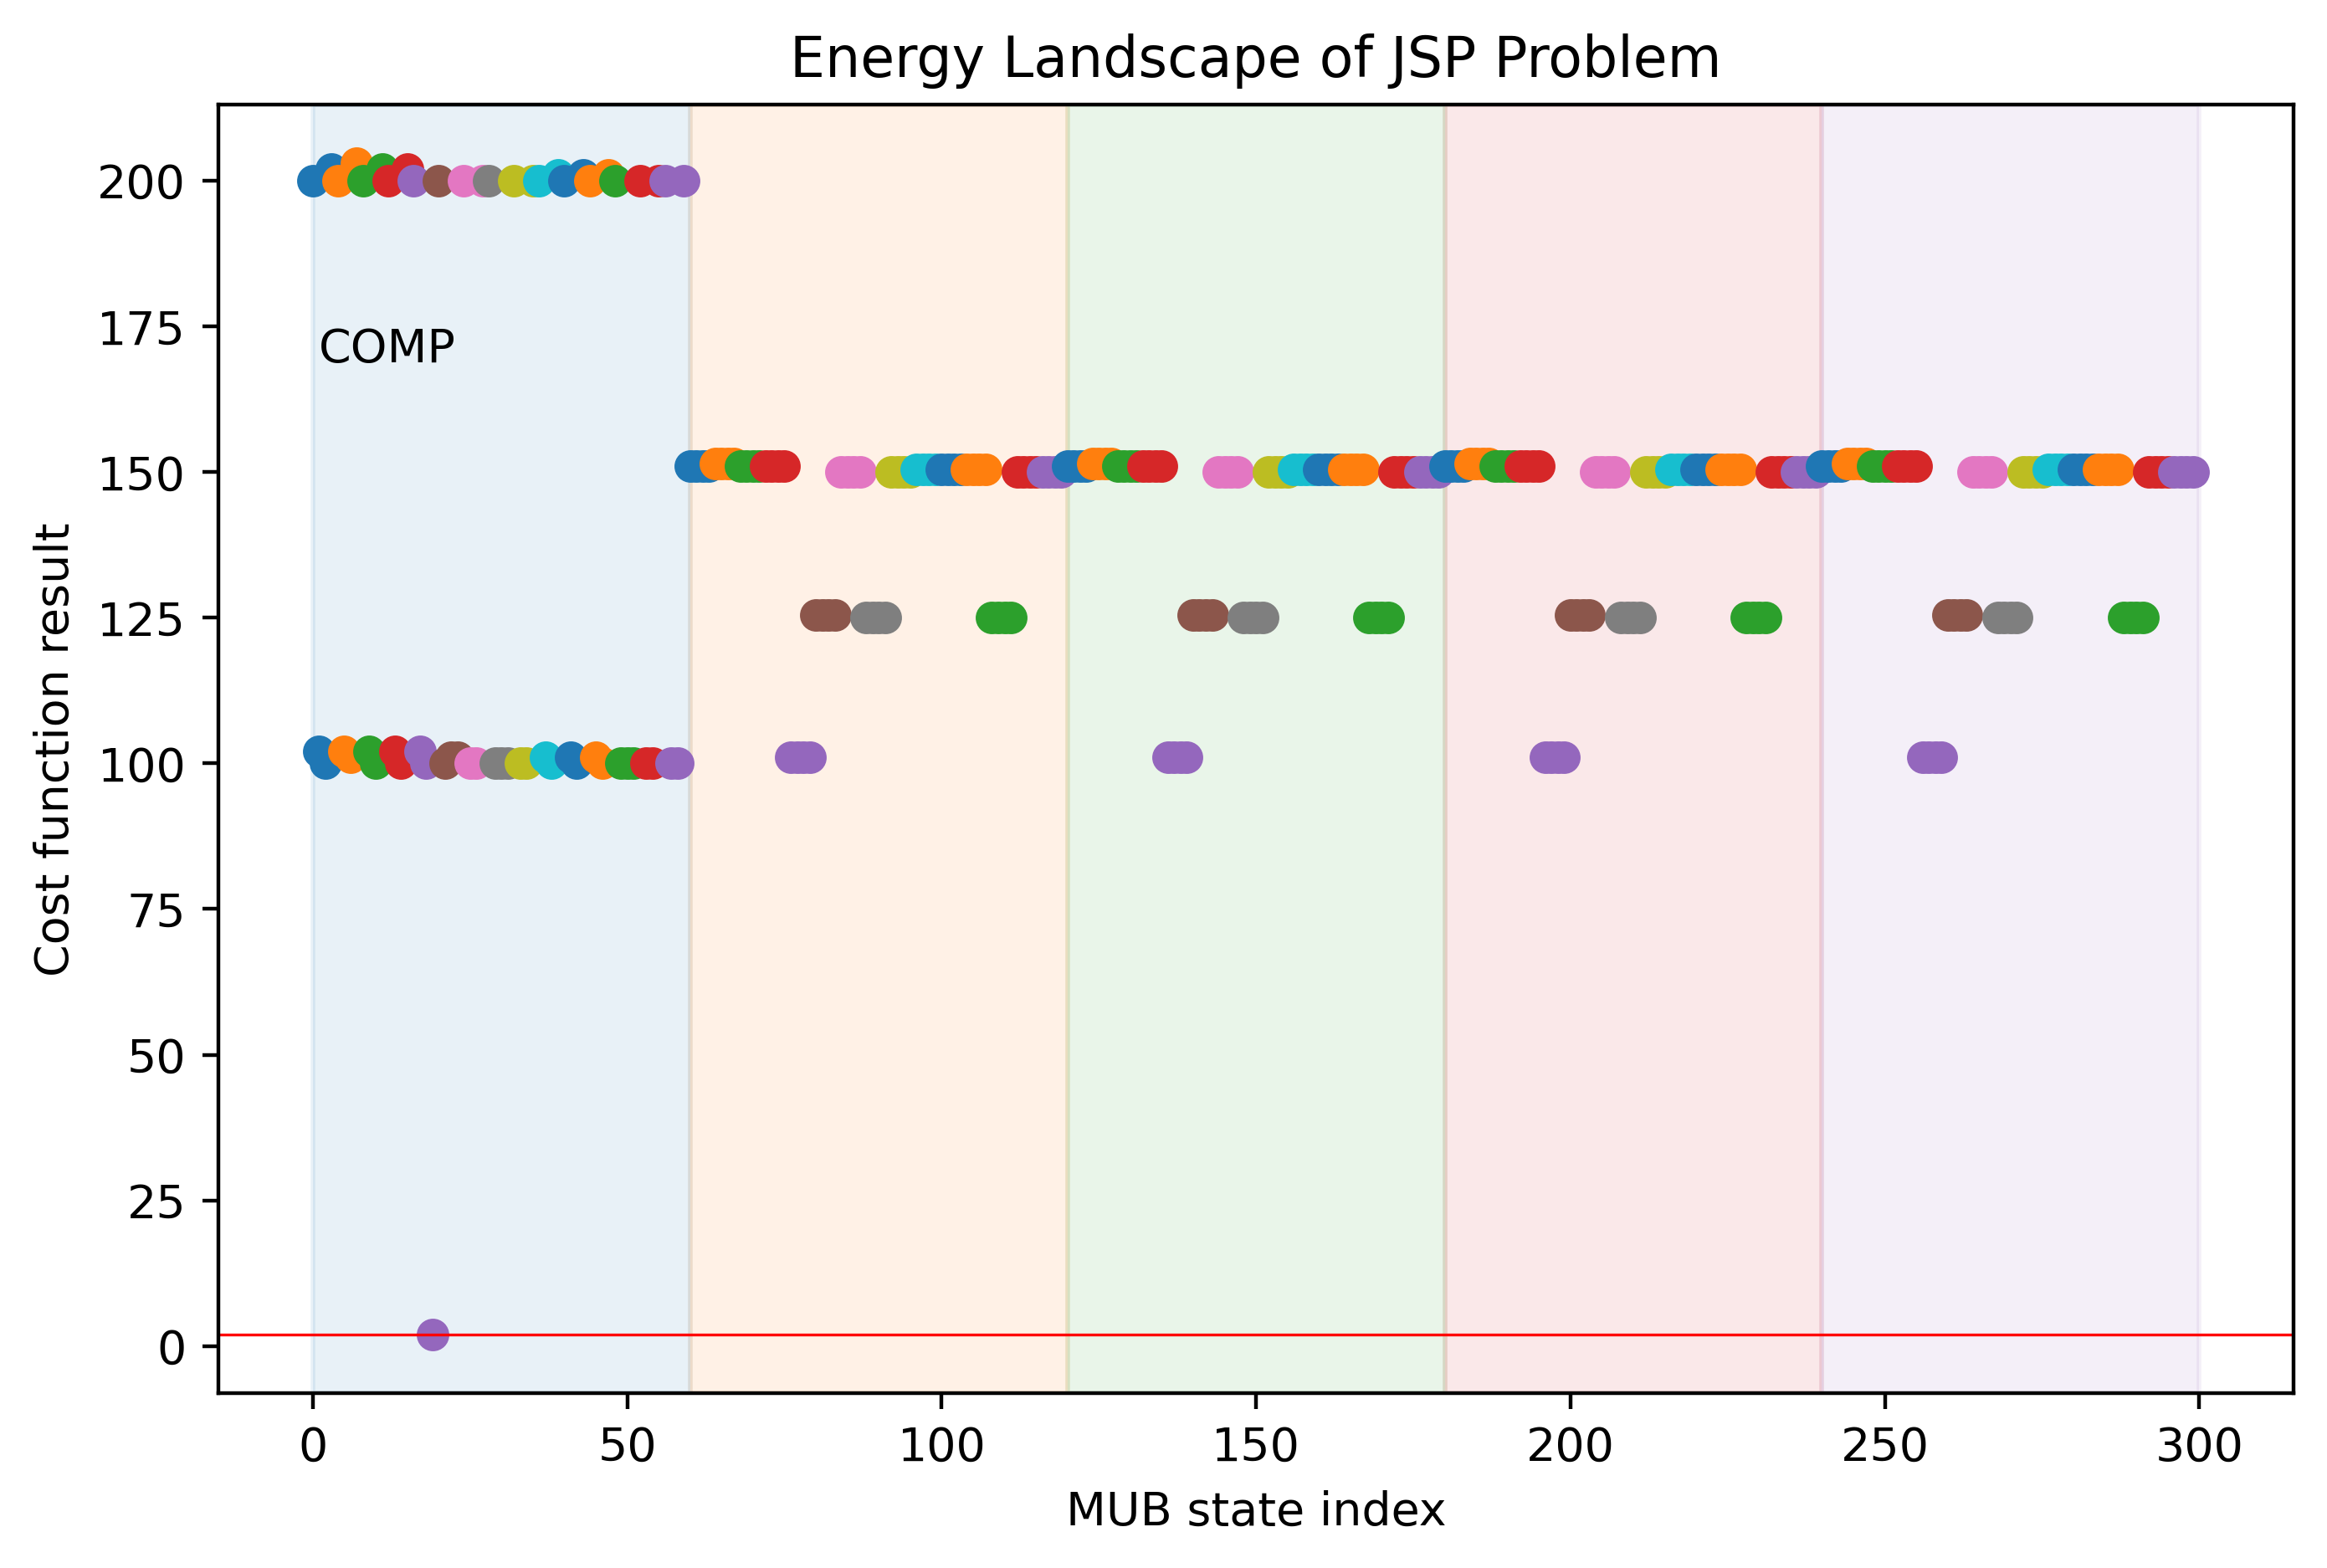

Energy Histogram:


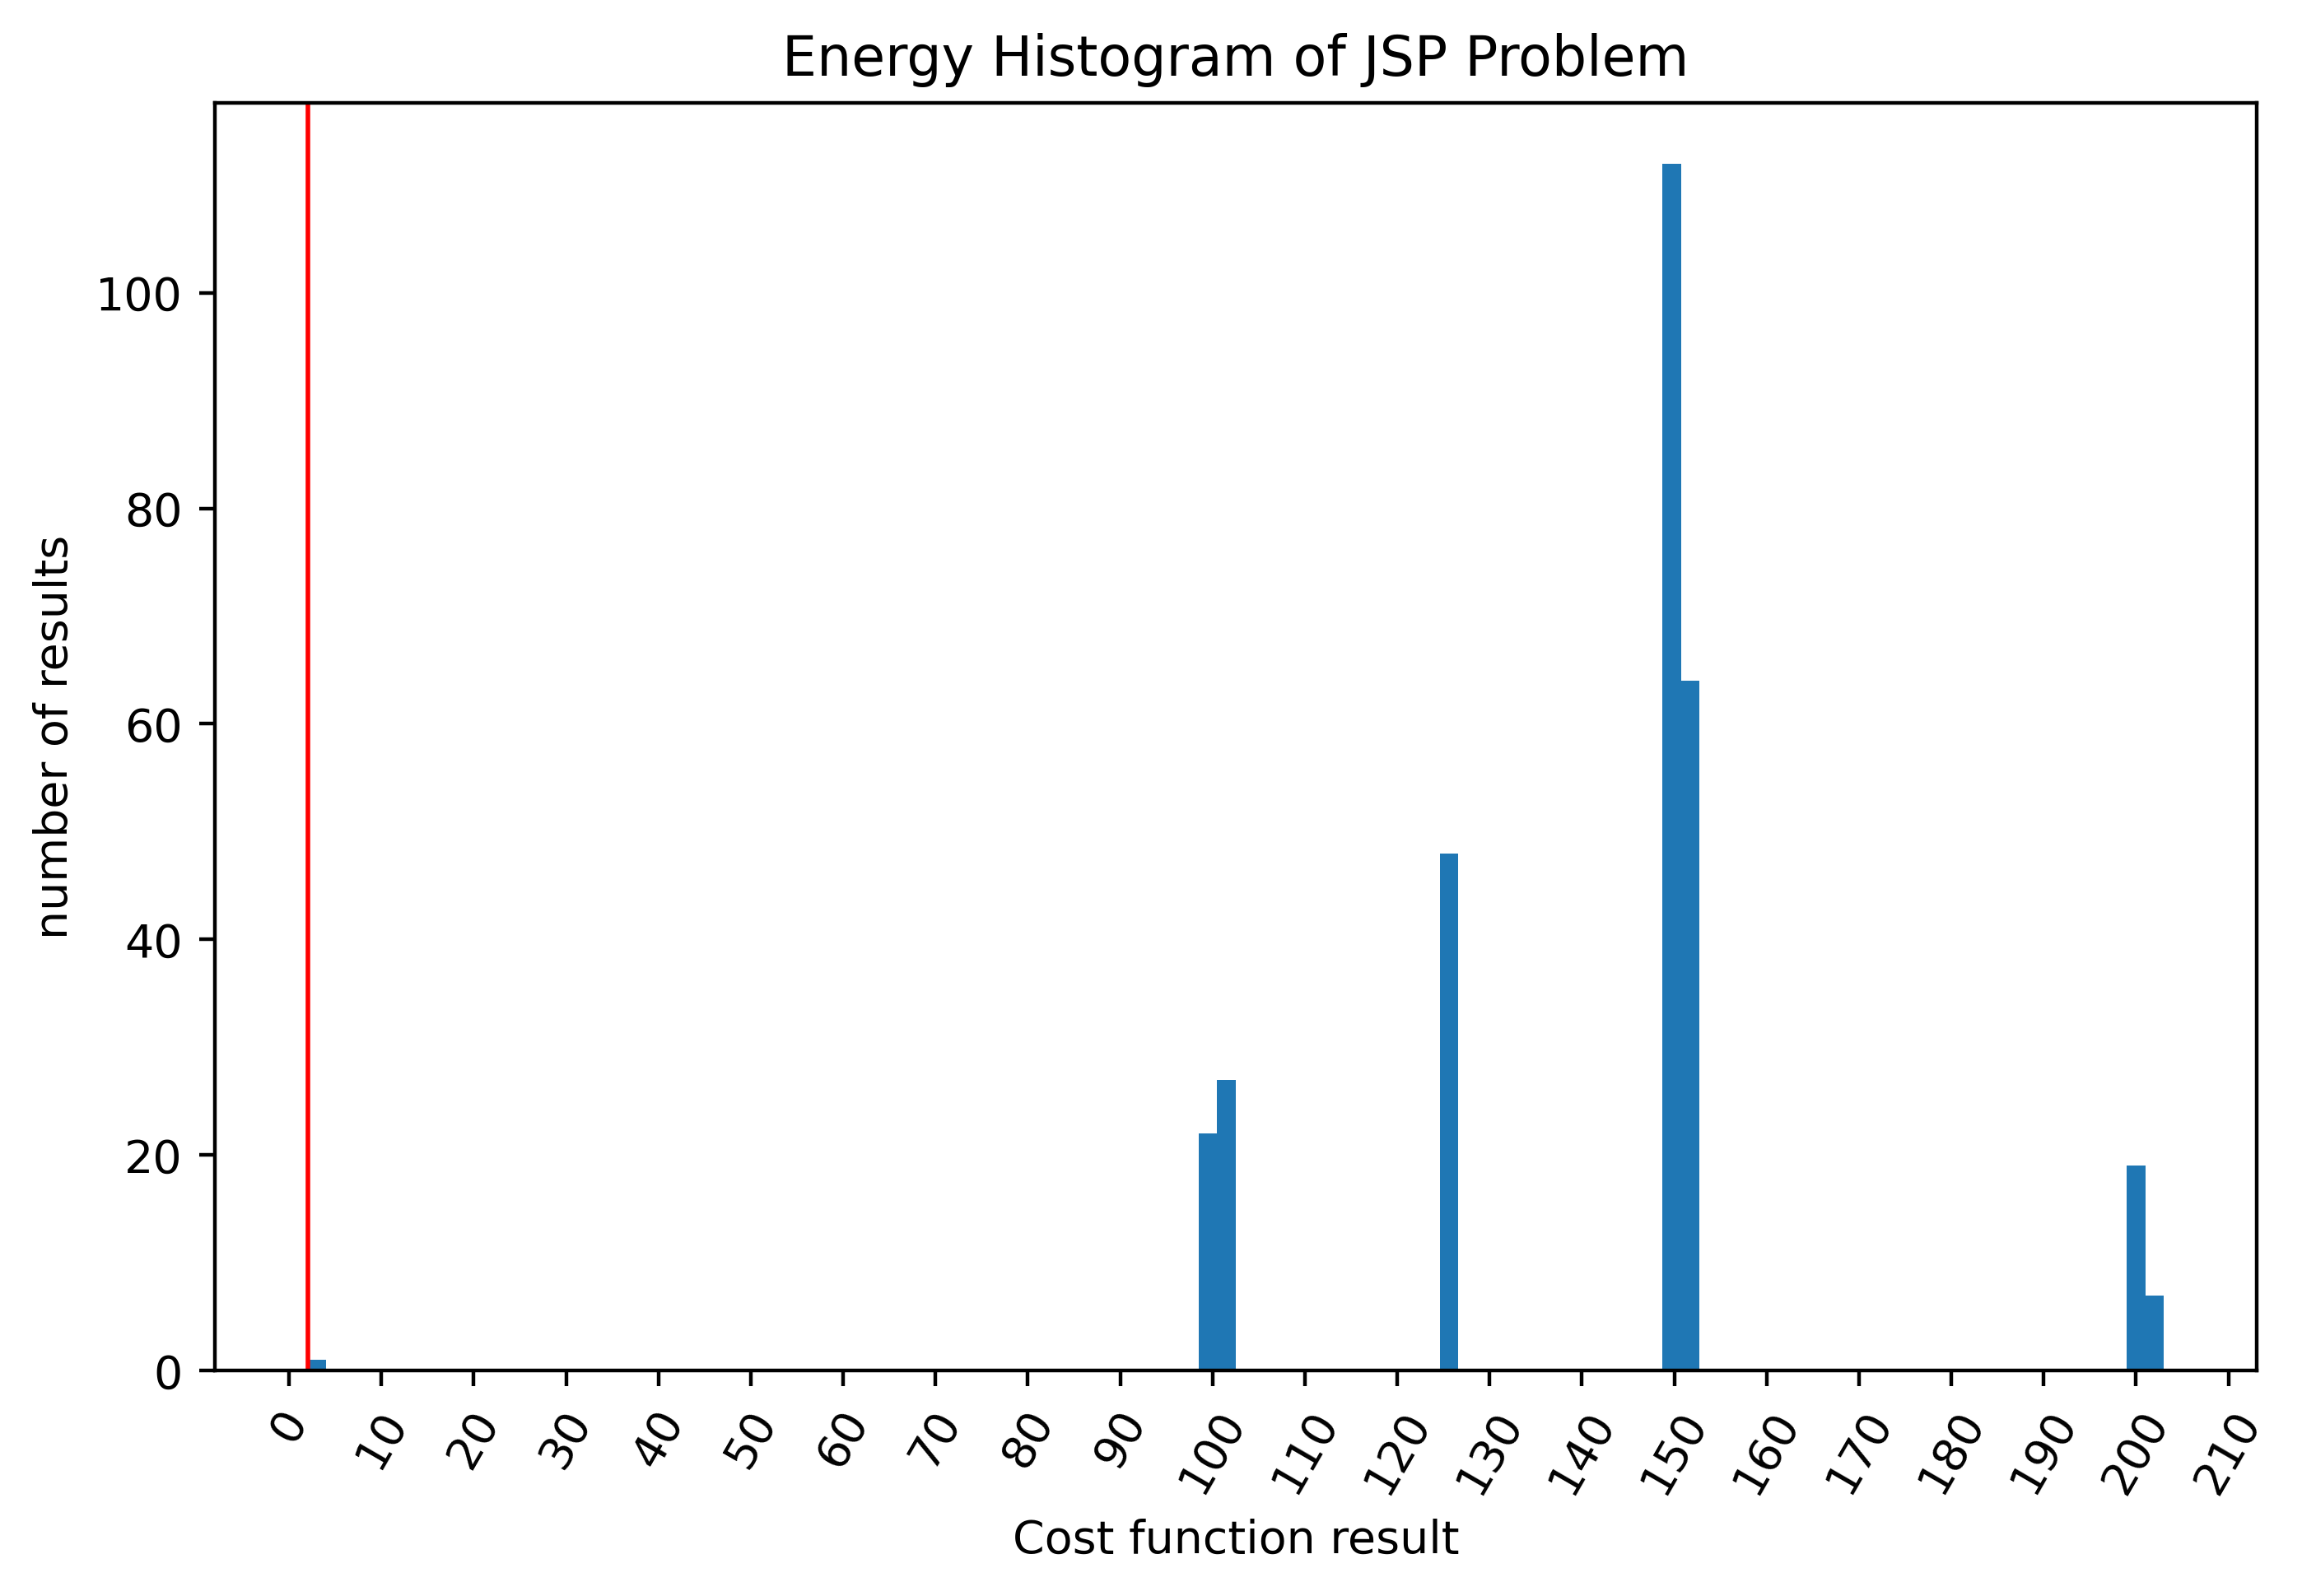

In [177]:
from experiment_utils import *

#####

landscape = run_and_record_landscape(H_total_JSP, 2, "JSP Problem")

In [178]:
from experiment_utils import *

def gen_expressive_ansatz_1qubit(num) -> QuantumCircuit:
    thetas = [0] * num
    circ = QuantumCircuit(1)
    circ.u(*thetas, 0)
    return circ, thetas
#, *gen_expressive_ansatz_1qubit(task.num_qubits)
run_and_record_vqe_expressive(landscape, True)

The operator SparsePauliOp(['IIIIII', 'IIIIII', 'IIIIII', 'ZIIIII', 'IZIIII', 'ZZIIII', 'IIIIII', 'IIIIII', 'ZIIIII', 'IIIZII', 'ZIIZII', 'IIIIII', 'IIIIII', 'IIZIII', 'IIIZII', 'IIZZII', 'IIIIII', 'IIIIII', 'IIZIII', 'IIIIIZ', 'IIZIIZ', 'IIIIII', 'IIIIII', 'IIIIZI', 'IIIIIZ', 'IIIIZZ', 'IIIIII', 'IIIIII', 'IIIIII', 'ZIIIII', 'IZIIII', 'ZZIIII', 'IIIIII', 'IIIIII', 'ZIIIII', 'IIIZII', 'ZIIZII', 'IIIIII', 'IIIIII', 'IIZIII', 'IZIIII', 'IZZIII', 'IIIIII', 'IIIIII', 'IIZIII', 'IIIZII', 'IIZZII', 'IIIIII', 'IIIIII', 'IIZIII', 'IIIIIZ', 'IIZIIZ', 'IIIIII', 'IIIIII', 'IIIIZI', 'IZIIII', 'IZIIZI', 'IIIIII', 'IIIIII', 'IIIIZI', 'IIIZII', 'IIIZZI', 'IIIIII', 'IIIIII', 'IIIIZI', 'IIIIIZ', 'IIIIZZ', 'IIIIII', 'IIIIII', 'ZIIIII', 'IIZIII', 'IIIIZI', 'IIIIII', 'ZIZIII', 'ZIIIZI', 'ZIZIII', 'IIIIII', 'IIZIZI', 'ZIIIZI', 'IIZIZI', 'IIIIII', 'IIIIII', 'IZIIII', 'IIIZII', 'IIIIIZ', 'IIIIII', 'IZIZII', 'IZIIIZ', 'IZIZII', 'IIIIII', 'IIIZIZ', 'IZIIIZ', 'IIIZIZ', 'IIIIII', 'IIIIII', 'IIIIII', 'IZIIII', 'I

AttributeError: 'NoneType' object has no attribute 'num_parameters'

In [ ]:
# def vector_to_spherical_angles(v):
#     # Ensure the input is a numpy array and normalized
#     v = np.asarray(v)
#     assert np.isclose(np.linalg.norm(v), 1), f"The vector {v} must be normalized."
    
#     n = len(v)
#     angles = np.zeros(n - 1)

#     # Calculate the angles
#     for i in range(0, n - 1):
#         # Calculate the angle theta_i
#         # Use the norm of the remaining dimensions
#         norm_remaining = np.linalg.norm(v[i+1:])
#         angles[i] = np.arctan2(norm_remaining, v[i])
    
#     return angles

# def spherical_angles_to_vector(angles):
#     # Ensure the input is a numpy array
#     angles = np.asarray(angles)
#     n = len(angles) + 1  # Number of dimensions
    
#     # Initialize the unit vector
#     v = np.zeros(n)
    
#     # Calculate the first coordinate
#     v[0] = np.cos(angles[0])
    
#     # Calculate the remaining coordinates
#     for i in range(1, n):
#         # Compute the product of sines for the previous angles
#         if i < n - 1:
#             sin_product = np.prod(np.sin(angles[:i]))  # Product of sines for angles up to i-1
#             v[i] = sin_product * np.cos(angles[i])
#         else:
#             # For the last coordinate, we use the product of sines for all previous angles
#             v[i] = np.prod(np.sin(angles[:i]))  # This is sin(theta_1) * sin(theta_2) * ... * sin(theta_{n-2})

#     return v

# test_v = np.array([1/np.sqrt(5),1/np.sqrt(2),1/np.sqrt(10/3)])
# print(vector_to_spherical_angles(test_v))
# print(np.isclose(spherical_angles_to_vector(vector_to_spherical_angles(test_v)), test_v))

# def get_directions(v, step_size):
#     # Ensure the input is a numpy array
#     v = np.asarray(v)
#     directions = []
    
#     # Iterate over each element in the vector
#     for i in range(len(v)):
#         # Create a copy of the original vector
#         v_plus = v.copy()
#         v_minus = v.copy()
        
#         # Modify the i-th element
#         v_plus[i] += step_size
#         v_minus[i] -= step_size
        
#         # Append the new vectors to the directions list
#         directions.append(v_plus)
#         directions.append(v_minus)
    
#     return directions

# def optimizer(H, initial_guess, step_size=0.01):
#     best_vector_angles = vector_to_spherical_angles(initial_guess)
#     print(best_vector_angles)
#     best_value = get_eigenvalue_sparse(initial_guess, H)
#     print(best_value)
    
#     for iterations in range(500):
#         #Pick best direction
#         for nearby_step in get_directions(best_vector_angles, step_size):
#             new_value = get_eigenvalue_sparse(spherical_angles_to_vector(nearby_step), H)
#             print("direction")
#             if(best_value > new_value):
#                 best_value = new_value
#                 best_vector_angles = nearby_step
#         print(best_vector_angles)
    
#     return best_value, spherical_angles_to_vector(best_vector_angles)

In [ ]:
# from scipy.sparse import diags

# H_diag_sparse = diags(H_diag.reshape(-1,))
# initial = np.zeros(shape=(H_diag.shape[0],))
# initial[0] = 1

# optimizer(H_diag, initial)

**Quantum Exhaustive Binary Search - QEBS**

In [151]:
from hamiltonians import get_expectation_value
from qiskit.quantum_info import Statevector

state_string = "+" * task.num_qubits

for i in range(task.num_qubits):
    #If 0
    state_string_if_0 = state_string[:i] + "0" + state_string[i+1:]
    state_if_0 = initialize_state_from_string(state_string_if_0)
    #If 1
    state_string_if_1 = state_string[:i] + "1" + state_string[i+1:]
    state_if_1 = initialize_state_from_string(state_string_if_1)
    print(get_expectation_value(state_if_0, H_total_JSP), get_expectation_value(state_if_1, H_total_JSP))
    if get_expectation_value(state_if_0, H_total_JSP) >= get_expectation_value(state_if_1, H_total_JSP):
        state_string = state_string_if_1
    else:
        state_string = state_string_if_0

final_state = initialize_state_from_string(state_string)

print("Naive solution", state_string)

826.5 1126.5
676.5 976.5
526.5 826.5
426.5 626.5
351.5 501.5
301.0 402.0
251.0 351.0
251.0 251.0
200.0 302.0
Naive solution 000000010


**Simulated Annealing binary search**

In [153]:
def simulated_annealing_binary_search(hamiltonian, n, max_iterations, debug=True):
    # Initialize an empty prefix and a dictionary to track prefixes and their values
    prefixes = {"":1}
    best_solution = None
    best_solution_value = 1e9

    average_value = get_expectation_value(initialize_state_from_string("+" * n), hamiltonian)

    for _ in range(max_iterations):
        if len(prefixes) == 0:
            break

        # Sample a prefix with probability proportional to exp(-value(prefix))
        total_value = sum(np.exp(-value / average_value) for value in prefixes.values())
        probabilities = [np.exp(-value / average_value) / total_value for value in prefixes.values()]
        
        # Sample a prefix based on the calculated probabilities
        sampled_prefix = np.random.choice(list(prefixes.keys()), p=probabilities)
        print(f"Sampled {sampled_prefix}") if debug else None
        del prefixes[sampled_prefix]

        # Check the value of adding a '0' to the sampled prefix
        prefix_with_zero = sampled_prefix + "0" + "+" * (n-len(sampled_prefix)-1)
        if len(sampled_prefix) + 1 < n:
            prefixes[sampled_prefix + "0"] = get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian)
        elif get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian) < best_solution_value:
            best_solution_value = get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian)
            best_solution = sampled_prefix + "0"
            print(f"Landed on final state {best_solution}") if debug else None

        # Check the value of adding a '1' to the sampled prefix
        prefix_with_one = sampled_prefix + "1" + "+" * (n-len(sampled_prefix)-1)
        if len(sampled_prefix) + 1 < n:
            prefixes[sampled_prefix + "1"] = get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian)
        elif get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian) < best_solution_value:
            best_solution_value = get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian)
            best_solution = sampled_prefix + "1"
            print(f"Landed on final state {best_solution}") if debug else None

        print(prefixes) if debug else None
        #print("normalized", [(k, prefixes[k] / average_value) for k in prefixes.keys()])

    # Return the most valuable prefix or any other relevant information
    if best_solution == None or (len(prefixes) > 0 and best_solution_value > min(prefixes.values())):
        proposed_solution = min(prefixes, key=prefixes.get)
    else:
        proposed_solution = best_solution
    

    if len(proposed_solution) < n:
        for _ in range(n - len(proposed_solution)):
            values, keys = np.array(list(prefixes.values())), np.array(list(prefixes.keys()))
            sampled_prefix = keys[np.argmin(values)]

            print(f"Greedy Sampled {sampled_prefix}") if debug else None
            del prefixes[sampled_prefix]

            # Check the value of adding a '0' to the sampled prefix
            prefix_with_zero = sampled_prefix + "0" + "+" * (n-len(sampled_prefix)-1)
            prefix_with_zero_value = get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian)
            if len(sampled_prefix) + 1 < n:
                prefixes[sampled_prefix + "0"] = prefix_with_zero_value
            
            # Check the value of adding a '1' to the sampled prefix
            prefix_with_one = sampled_prefix + "1" + "+" * (n-len(sampled_prefix)-1)
            prefix_with_one_value = get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian)
            if len(sampled_prefix) + 1 < n:
                prefixes[sampled_prefix + "1"] = prefix_with_one_value

            if len(sampled_prefix) + 1 == n:
                if prefix_with_zero_value < prefix_with_one_value:
                    return sampled_prefix + "0"
                else:
                    return sampled_prefix + "1"

            print("Greedy", prefixes) if debug else None
            #print("Greedy normalized", [(k, prefixes[k] / average_value) for k in prefixes.keys()])
    else:
        return proposed_solution

print("Found Solution", simulated_annealing_binary_search(H_total_JSP, task.num_qubits, 10))

Sampled 
{'0': np.float64(826.5), '1': np.float64(1126.5)}
Sampled 0
{'1': np.float64(1126.5), '00': np.float64(676.5), '01': np.float64(976.5)}
Sampled 00
{'1': np.float64(1126.5), '01': np.float64(976.5), '000': np.float64(526.5), '001': np.float64(826.5)}
Sampled 000
{'1': np.float64(1126.5), '01': np.float64(976.5), '001': np.float64(826.5), '0000': np.float64(426.5), '0001': np.float64(626.5)}
Sampled 001
{'1': np.float64(1126.5), '01': np.float64(976.5), '0000': np.float64(426.5), '0001': np.float64(626.5), '0010': np.float64(676.5), '0011': np.float64(976.5)}
Sampled 0010
{'1': np.float64(1126.5), '01': np.float64(976.5), '0000': np.float64(426.5), '0001': np.float64(626.5), '0011': np.float64(976.5), '00100': np.float64(551.5), '00101': np.float64(801.5)}
Sampled 0011
{'1': np.float64(1126.5), '01': np.float64(976.5), '0000': np.float64(426.5), '0001': np.float64(626.5), '00100': np.float64(551.5), '00101': np.float64(801.5), '00110': np.float64(751.5), '00111': np.float64(1201

**Benchmark - Probability of success vs number of iterations**

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.05, 0.05, 0.0, 0.05, 0.1]


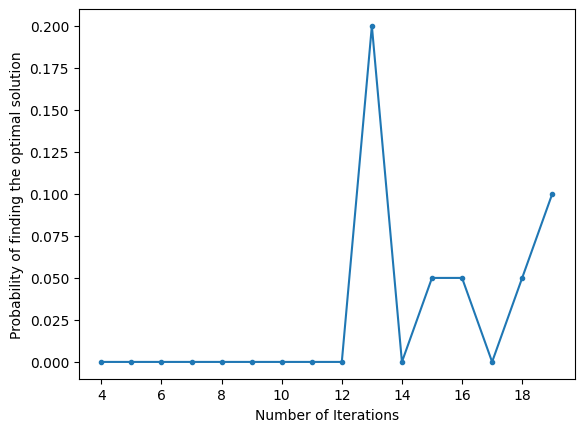

In [154]:
N_MAX = 20
iter_nums = list(range(4, 20))
probabilities = []

for iter_num in iter_nums:
    success = 0
    for N in range(N_MAX):
        if simulated_annealing_binary_search(H_total_JSP, task.num_qubits, iter_num, debug=False) == binary_solution:
            success += 1
    probabilities += [success / N_MAX]

print(probabilities)
plt.plot(iter_nums, probabilities, marker='.')
plt.xlabel("Number of Iterations")
plt.ylabel("Probability of finding the optimal solution")

plt.show()